# Libraries

In [1]:
! pip install transformers timm albumentations --quiet
! pip install ipywidgets --quiet

In [2]:
# Standard Libraries
import os
import random
from collections import Counter

# Numerical and Data Handling Libraries
import numpy as np
import pandas as pd

# Image Processing Libraries
import cv2
from PIL import Image

# Plotting and Visualization
import matplotlib.pyplot as plt

# PyTorch and Torchvision
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Transformers for Vision Models
from transformers import ViTConfig, ViTForImageClassification, ViTImageProcessor

# Utility Libraries
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# jupyter nbextension enable --py widgetsnbextension
from google.colab import output
output.enable_custom_widget_manager()

import shutil

# Preprocessing & Augmentation

## Split the Dataset by 80 / 20

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Path to the dataset
base_dir = '/kaggle/input/bdma-07-competition/BDMA7_project_files'
train_dir = os.path.join(base_dir, 'train_images')
val_dir = os.path.join(base_dir, 'val_images')
output_base_dir = '/kaggle/working/New_Split_Dataset'  # Kaggle working directory for output
new_train_dir = os.path.join(output_base_dir, 'train_images')
new_val_dir = os.path.join(output_base_dir, 'val_images')

# Create new directories for reorganized data
os.makedirs(new_train_dir, exist_ok=True)
os.makedirs(new_val_dir, exist_ok=True)

# Reorganize each class
for class_name in os.listdir(train_dir):
    class_train_path = os.path.join(train_dir, class_name)
    class_val_path = os.path.join(val_dir, class_name)
    
    # Combine train and validation images for splitting
    all_images = []
    if os.path.isdir(class_train_path):
        all_images.extend([os.path.join(class_train_path, img) for img in os.listdir(class_train_path)])
    if os.path.isdir(class_val_path):
        all_images.extend([os.path.join(class_val_path, img) for img in os.listdir(class_val_path)])
    
    # Split into 80% train, 20% validation
    train_images, val_images = train_test_split(all_images, test_size=0.2, random_state=42)
    
    # Create class directories in new_train_dir and new_val_dir
    new_class_train_path = os.path.join(new_train_dir, class_name)
    new_class_val_path = os.path.join(new_val_dir, class_name)
    os.makedirs(new_class_train_path, exist_ok=True)
    os.makedirs(new_class_val_path, exist_ok=True)
    
    # Move images to respective directories
    for img_path in train_images:
        shutil.copy(img_path, new_class_train_path)
    for img_path in val_images:
        shutil.copy(img_path, new_class_val_path)

print(f"Dataset reorganization complete. New train and validation sets are saved in {output_base_dir}.")

Dataset reorganization complete. New train and validation sets are saved in /kaggle/working/New_Split_Dataset.


## Preprocess by DeepLabV3 Remove Background

In [4]:
import os
import torch
import torchvision.transforms as T
from PIL import Image
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
import numpy as np

# Set data paths
train_dir = "/kaggle/input/bdma-07-competition/BDMA7_project_files/train_images"
val_dir = "/kaggle/input/bdma-07-competition/BDMA7_project_files/val_images"
test_dir = "/kaggle/input/bdma-07-competition/BDMA7_project_files/test_images/mistery_cat"
output_dir = "/kaggle/working/processed_images"

# Create output directory
os.makedirs(output_dir, exist_ok=True)

# Load the pretrained DeepLabV3+ model (ResNet101 backbone)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained model with correct weights handling
weights = DeepLabV3_ResNet101_Weights.DEFAULT
model = deeplabv3_resnet101(weights=weights).to(device)
model.eval()

# Image preprocessing (fixed "mean" and "std" issue)
def preprocess_image(image_path):
    """Preprocess the input image for the DeepLabV3+ model."""
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([
        T.Resize((512, 512)),
        T.ToTensor(),
        T.Normalize(mean=weights.transforms().mean, std=weights.transforms().std),  # FIXED
    ])
    return transform(image).unsqueeze(0), image

# Post-processing: apply the segmentation mask to the original image
def apply_mask(image, mask):
    """Apply the segmentation mask to the original image to remove the background."""
    mask = mask.cpu().numpy()
    mask = (mask > 0.5).astype(np.uint8)  # Binarize the mask
    mask = Image.fromarray(mask * 255).resize(image.size, Image.BILINEAR)
    mask = np.array(mask) / 255
    image_np = np.array(image)
    result = (image_np * np.expand_dims(mask, axis=-1)).astype(np.uint8)
    return Image.fromarray(result)

def process_directory(input_dir, output_subdir):
    """Process all images in a directory, including subdirectories, and save the results."""
    output_path = os.path.join(output_dir, output_subdir)
    os.makedirs(output_path, exist_ok=True)

    print(f"🔍 Removing images Background in: {input_dir}")

    # Walk through all subdirectories and files
    for root, _, files in os.walk(input_dir):
        for filename in files:
            file_path = os.path.join(root, filename)

            # Process only image files
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                # Recreate subdirectory structure in output
                relative_path = os.path.relpath(root, input_dir)
                sub_output_path = os.path.join(output_path, relative_path)
                os.makedirs(sub_output_path, exist_ok=True)

                try:
                    # Preprocess the image
                    input_tensor, original_image = preprocess_image(file_path)
                    input_tensor = input_tensor.to(device)

                    # Inference
                    with torch.no_grad():
                        output = model(input_tensor)['out']
                    mask = torch.argmax(output.squeeze(), dim=0)

                    # Apply the mask
                    result_image = apply_mask(original_image, mask)

                    # Save the result
                    result_path = os.path.join(sub_output_path, filename)
                    result_image.save(result_path)
                    # print(f"✅ Processed and saved: {result_path}")

                except Exception as e:
                    print(f"❌ Error processing {file_path}: {e}")  # Debugging output

# Process training, validation, and test datasets
print("Processing training images...")
process_directory(train_dir, "train_images")

print("Processing validation images...")
process_directory(val_dir, "val_images")

print("Processing test images...")
process_directory(test_dir, "test_images")

print(f"All images processed and saved in {output_dir}")

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 164MB/s]


Processing training images...
🔍 Removing images Background in: /kaggle/input/bdma-07-competition/BDMA7_project_files/train_images
Processing validation images...
🔍 Removing images Background in: /kaggle/input/bdma-07-competition/BDMA7_project_files/val_images
Processing test images...
🔍 Removing images Background in: /kaggle/input/bdma-07-competition/BDMA7_project_files/test_images/mistery_cat
All images processed and saved in /kaggle/working/processed_images


In [5]:
import os

train_output_dir = "/kaggle/working/processed_images/train_images"

# List all files in processed directory
print("Processed train images:", os.listdir(train_output_dir))

Processed train images: ['Groove_billed_Ani', 'Indigo_Bunting', 'Painted_Bunting', 'Brandt_Cormorant', 'Yellow_breasted_Chat', 'Bobolink', 'Bronzed_Cowbird', 'Red_winged_Blackbird', 'Rusty_Blackbird', 'Brown_Creeper', 'Black_billed_Cuckoo', 'Brewer_Blackbird', 'Yellow_billed_Cuckoo', 'Yellow_headed_Blackbird', 'Gray_Catbird', 'American_Crow', 'Gray_crowned_Rosy_Finch', 'Fish_Crow', 'Eastern_Towhee', 'Lazuli_Bunting']


## Data Augmentation

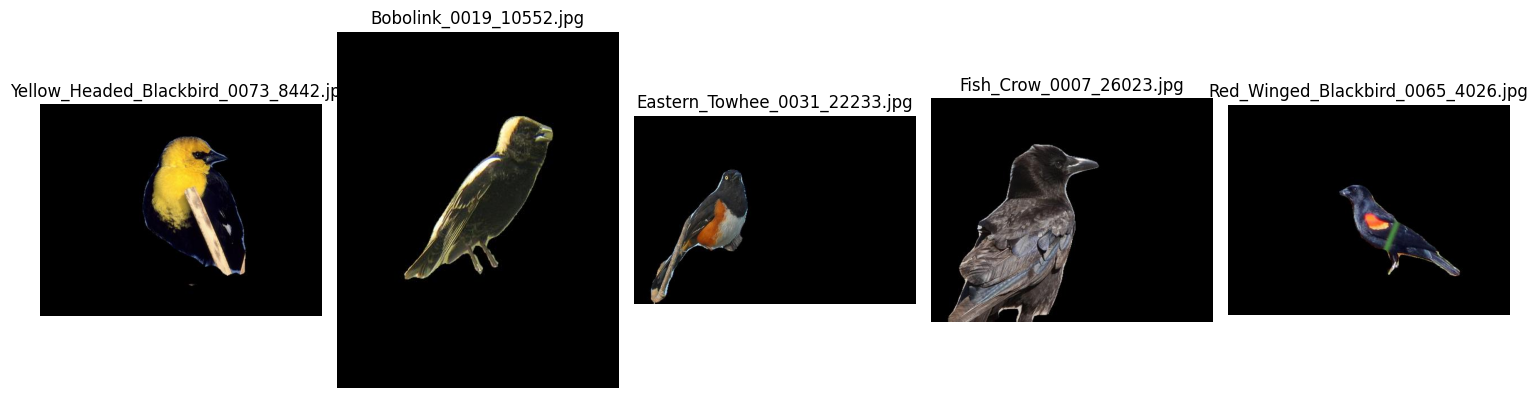

In [6]:
# Directory containing processed images
output_dir = "/kaggle/working/processed_images/train_images"

# Function to randomly select and display images
def display_random_images(output_dir, num_images=5):
    images = []
    for root, _, files in os.walk(output_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                images.append(os.path.join(root, file))
    
    # Randomly sample images
    sampled_images = random.sample(images, min(len(images), num_images))
    
    # Display sampled images
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(sampled_images):
        img = Image.open(img_path)
        plt.subplot(1, len(sampled_images), i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(os.path.basename(img_path))
    plt.tight_layout()
    plt.show()

# Display 5 random images
display_random_images(output_dir, num_images=5)

In [7]:
# Data augmentation (rotation)
train_dir = "/kaggle/working/processed_images/train_images"
output_dir = "/kaggle/working/preprocessed_images"

# Image processing parameters
img_size = (128, 128)  # Resize dimensions
rotation_angles = [-15, -10, -5, 5, 10, 15]  # Rotation angles

# Create output directory
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Data augmentation and saving
def preprocess_and_augment_images(input_dir, output_dir, img_size, angles):
    """
    Perform preprocessing (resize) and augmentation (rotation) on images.
    """
    for class_folder in tqdm(os.listdir(input_dir), desc="Processing Classes"):
        class_path = os.path.join(input_dir, class_folder)
        if not os.path.isdir(class_path):
            continue

        # Create output directory for each class
        class_output_path = os.path.join(output_dir, class_folder)
        os.makedirs(class_output_path, exist_ok=True)

        # Process each image
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path)

            if img is None:
                print(f"Warning: Unable to read image {img_path}")
                continue

            # Resize the image
            resized_img = cv2.resize(img, img_size)

            # Save the resized original image
            base_name = os.path.splitext(img_file)[0]
            cv2.imwrite(os.path.join(class_output_path, f"{base_name}_original.jpg"), resized_img)

            # Data augmentation (rotation)
            for angle in angles:
                # Calculate the rotation matrix
                h, w = resized_img.shape[:2]
                center = (w // 2, h // 2)
                rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

                # Rotate the image
                rotated_img = cv2.warpAffine(resized_img, rotation_matrix, (w, h))

                # Save the augmented image
                augmented_name = f"{base_name}_rotated_{angle}.jpg"
                cv2.imwrite(os.path.join(class_output_path, augmented_name), rotated_img)

# Execute preprocessing and augmentation
preprocess_and_augment_images(train_dir, output_dir, img_size, rotation_angles)

print("Data preprocessing and augmentation complete. Files saved to:", output_dir)

Processing Classes: 100%|██████████| 20/20 [00:03<00:00,  6.19it/s]

Data preprocessing and augmentation complete. Files saved to: /kaggle/working/preprocessed_images


In [8]:
## Data augmentation (flip)
def flip_image(image, flip_code):
    return cv2.flip(image, flip_code)

train_dir = "/kaggle/working/preprocessed_images"
output_dir = "/kaggle/working/preprocessed02_images"
# Define a list of flip codes
# flip_codes = [0, 1, -1]
flip_codes = [1]

# Iterate through subdirectories (classes) in the input directory
for root, dirs, files in os.walk(train_dir):
    for dir_name in dirs:
        input_class_dir = os.path.join(root, dir_name)
        output_class_dir = os.path.join(output_dir, dir_name)
        # Create the output directory if it doesn't exist
        if not os.path.exists(output_class_dir):
            os.makedirs(output_class_dir)
        # Iterate through files in the class directory
        for file in os.listdir(input_class_dir):
            if file.endswith(".jpg"):
                input_file_path = os.path.join(input_class_dir, file)
                # Read the image
                image = cv2.imread(input_file_path)
                
                # Copy the original image to the output directory
                output_original_file_path = os.path.join(output_class_dir, file)
                cv2.imwrite(output_original_file_path, image)
                
                # Generate flipped images for each flip operation
                for flip_code in flip_codes:
                    # Generate a new file name
                    base_name = os.path.splitext(file)[0]
                    output_file_name = f"{base_name}_flipped_{flip_code}.jpg"
                    output_file_path = os.path.join(output_class_dir, output_file_name)
                    # Perform the flip operation on the image
                    flipped_image = flip_image(image, flip_code)
                    cv2.imwrite(output_file_path, flipped_image)

# Vision Transformer Model

In [9]:
# train_dir = "/kaggle/working/preprocessed02_images"
# val_dir = "/kaggle/working/processed_images/val_images"

In [10]:
# # model_name = "google/vit-base-patch16-224-in21k"  # 224x224 Input，16x16 Chunk
# # Change to ViT-Large
# model_name = "google/vit-large-patch16-224-in21k"
# processor = ViTImageProcessor.from_pretrained(model_name)
# model = ViTForImageClassification.from_pretrained(
#     model_name,
#     num_labels=20,  # Number of Classes
#     ignore_mismatched_sizes=True  
# )

## Freeze feature layers of ViT

In [11]:
# # Freeze all feature layers of ViT (train only the classification head)
# for param in model.vit.parameters():
#     # param.requires_grad = False
#     param.requires_grad = False

# # Thaw the classification headers separately
# for param in model.classifier.parameters():
#     param.requires_grad = True

## Set layer-wise learning rate

In [12]:
# # Set layer-wise learning rate (feature layer learning rate is lower)
# optimizer = AdamW(
#     [
#         {"params": model.vit.parameters(), "lr": 1e-5},  # Feature extraction layer
#         {"params": model.classifier.parameters(), "lr": 3e-4}  # Classification Header
#     ],
#     weight_decay=0.01
# )

In [13]:
# # Verify that the classification layer is randomly initialized (correct state should be True)
# print(model.classifier.weight.mean().item())  # Should be close to 0 (normal distribution initialization)
# print(model.classifier.bias.mean().item())    # Should be close to 0

## Check Submission Classes Order

In [14]:
# submission_class_order = [
#     'Groove_billed_Ani',
#     'Red_winged_Blackbird',
#     'Rusty_Blackbird',
#     'Gray_Catbird',
#     'Brandt_Cormorant',
#     'Eastern_Towhee',
#     'Indigo_Bunting',
#     'Brewer_Blackbird',
#     'Painted_Bunting',
#     'Bobolink',
#     'Lazuli_Bunting',
#     'Yellow_headed_Blackbird',
#     'American_Crow',
#     'Fish_Crow',
#     'Brown_Creeper',
#     'Yellow_billed_Cuckoo',
#     'Yellow_breasted_Chat',
#     'Black_billed_Cuckoo',
#     'Gray_crowned_Rosy_Finch',
#     'Bronzed_Cowbird'
# ]

In [15]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# class BirdDataset(Dataset):
#     def __init__(self, main_dir, transform=None):
#         self.dataset = ImageFolder(root=main_dir, transform=transform)
#         self.class_to_idx = self.dataset.class_to_idx
        
#     def __len__(self):
#         return len(self.dataset)
    
#     def __getitem__(self, idx):
#         image, label = self.dataset[idx]
#         return image, label

# train_transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.RandomCrop(224),
#     transforms.RandomHorizontalFlip(),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
# ])

# val_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
# ])

# train_dataset = BirdDataset(train_dir, transform=train_transform)
# val_dataset = BirdDataset(val_dir, transform=val_transform)

# def validate_class_order(train_class_order, submission_order):
#     """Make sure the category names and order of both lists are exactly the same"""
#     if len(train_class_order) != len(submission_order):
#         raise ValueError(f"The number of categories does not match! Training set: {len(train_class_order)}, Submission Requirements: {len(submission_order)}")
    
#     for train_cls, sub_cls in zip(train_class_order, submission_order):
#         if train_cls != sub_cls:
#             raise ValueError(f"Inconsistent order: training set '{train_cls}' vs Submission Requirements '{sub_cls}'")
#     return True

# train_class_order = sorted(train_dataset.class_to_idx.keys())

# try:
#     validate_class_order(train_class_order, submission_class_order)
# except ValueError as e:
#     print("Category order inconsistency detected, automatically correcting...")
#     from torchvision.datasets import DatasetFolder
    
#     class OrderedImageFolder(DatasetFolder):
#         """Forces the data sets of categories to be loaded in a specified order"""
#         def __init__(self, root, class_order, transform=None):
#             self.class_order = class_order
#             super().__init__(
#                 root,
#                 loader=lambda x: Image.open(x).convert("RGB"),
#                 extensions=('jpg', 'jpeg', 'png'),
#                 transform=transform,
#                 target_transform=None
#             )
            
#         def find_classes(self, directory):
#             classes = self.class_order 
#             class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
#             return classes, class_to_idx
    
#     train_dataset = OrderedImageFolder(
#         train_dir, 
#         class_order=submission_class_order,
#         transform=train_transform
#     )
#     val_dataset = OrderedImageFolder(
#         val_dir,
#         class_order=submission_class_order,
#         transform=val_transform
#     )
    
#     print("Corrected category order：", train_dataset.classes)
    
# # Category index validation (ensuring consistency with submission format)
# assert sorted(train_dataset.class_to_idx.keys()) == sorted(submission_class_order), "Category order mismatch！"

## Model Train

In [16]:
# # Define Dataloaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

# # Define loss function and move model to device
# criterion = torch.nn.CrossEntropyLoss()
# model = model.to(device)

# # Function to train a single epoch
# def train_epoch(model, loader, optimizer, scaler):
#     model.train()
#     total_loss = 0
#     correct = 0
    
#     for images, labels in loader:
#         images = images.to(device)
#         labels = labels.to(device)
        
#         optimizer.zero_grad()
        
#         with torch.amp.autocast(device_type='cuda'):
#             outputs = model(images)
#             loss = criterion(outputs.logits, labels)
        
#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()
        
#         total_loss += loss.item() * images.size(0)
#         preds = torch.argmax(outputs.logits, dim=1)
#         correct += (preds == labels).sum().item()
    
#     avg_loss = total_loss / len(loader.dataset)
#     accuracy = correct / len(loader.dataset)
#     return avg_loss, accuracy

# # Function to validate the model
# def validate(model, loader):
#     model.eval()
#     total_loss = 0
#     correct = 0
    
#     with torch.no_grad():
#         for images, labels in loader:
#             images = images.to(device)
#             labels = labels.to(device)
            
#             outputs = model(images)
#             loss = criterion(outputs.logits, labels)
            
#             total_loss += loss.item() * images.size(0)
#             preds = torch.argmax(outputs.logits, dim=1)
#             correct += (preds == labels).sum().item()
    
#     avg_loss = total_loss / len(loader.dataset)
#     accuracy = correct / len(loader.dataset)
#     return avg_loss, accuracy

# scaler = torch.amp.GradScaler()
# history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# best_val_loss = float('inf')
# best_model_state = None

# for epoch in range(100):
#     train_loss, train_acc = train_epoch(model, train_loader, optimizer, scaler)
#     val_loss, val_acc = validate(model, val_loader)
    
#     history['train_loss'].append(train_loss)
#     history['val_loss'].append(val_loss)
#     history['train_acc'].append(train_acc)
#     history['val_acc'].append(val_acc)
    
#     print(f"Epoch {epoch+1:02d}:")
#     print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
#     print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}\n")
    
#     # Save the best model
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         best_model_state = model.state_dict()

# # Load the best model at the end of training
# best_model_path = "/kaggle/working/best_vit_model.pth"
# if best_model_state:
#     model.load_state_dict(best_model_state)
#     torch.save(best_model_state, best_model_path)
#     print("Best model loaded from training with lowest validation loss.")

# # Plot training history
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(history['train_loss'], label='Train')
# plt.plot(history['val_loss'], label='Validation')
# plt.title('Loss Curve')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history['train_acc'], label='Train')
# plt.plot(history['val_acc'], label='Validation')
# plt.title('Accuracy Curve')
# plt.legend()
# plt.show()

## Save Model

In [17]:
# save_dir = "/kaggle/working/vit_model"
# os.makedirs(save_dir, exist_ok=True)

# torch.save(model.state_dict(), os.path.join(save_dir, "vit_model_weights.pth"))

# processor.save_pretrained(save_dir)

# class_info = {
#     "class_order": submission_class_order,
#     "class_to_idx": train_dataset.class_to_idx,
#     "idx_to_class": {v: k for k, v in train_dataset.class_to_idx.items()}
# }

# torch.save(class_info, os.path.join(save_dir, "class_info.pth"))

# train_config = {
#     "epochs_trained": len(history['train_loss']),
#     "best_val_acc": max(history['val_acc']),
#     "optimizer_state": optimizer.state_dict()
# }

# torch.save(train_config, os.path.join(save_dir, "train_config.pth"))

# print(f"Model Saved to：{save_dir}")

# # Second Hugging Face Format Save
# model.save_pretrained(save_dir)
# processor.save_pretrained(save_dir)

# with open(os.path.join(save_dir, "class_info.txt"), "w") as f:
#     f.write("\n".join(submission_class_order))

# print("HuggingFace Format Saved")

# Test and Generate Submission File

In [18]:
# # Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Define class order for submission
# submission_class_order = [
#     'Groove_billed_Ani', 'Red_winged_Blackbird', 'Rusty_Blackbird', 'Gray_Catbird',
#     'Brandt_Cormorant', 'Eastern_Towhee', 'Indigo_Bunting', 'Brewer_Blackbird',
#     'Painted_Bunting', 'Bobolink', 'Lazuli_Bunting', 'Yellow_headed_Blackbird',
#     'American_Crow', 'Fish_Crow', 'Brown_Creeper', 'Yellow_billed_Cuckoo',
#     'Yellow_breasted_Chat', 'Black_billed_Cuckoo', 'Gray_crowned_Rosy_Finch', 'Bronzed_Cowbird'
# ]

# # Image transformation for validation
# processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
# val_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
# ])

# # Custom Dataset class for test images
# class CompetitionTestDataset(Dataset):
#     def __init__(self, test_dir, transform=None):
#         self.test_dir = test_dir
#         self.image_files = sorted(os.listdir(test_dir))
#         self.image_paths = [os.path.join(test_dir, f) for f in self.image_files]
#         self.transform = transform
        
#     def __len__(self):
#         return len(self.image_paths)
    
#     def __getitem__(self, idx):
#         image = Image.open(self.image_paths[idx]).convert('RGB')
#         if self.transform:
#             image = self.transform(image)
#         return image, os.path.basename(self.image_paths[idx])

# # Load best saved model
# def load_best_model(model, model_path):
#     model.load_state_dict(torch.load(model_path, map_location=device))
#     model.eval()
#     return model

# # Generate predictions using the best model
# def generate_submission(test_dir, best_model_path, output_csv="submission.csv"):
#     test_dataset = CompetitionTestDataset(test_dir, transform=val_transform)
#     test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)
    
#     config = ViTConfig.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=len(submission_class_order))
#     model = ViTForImageClassification(config).to(device)
#     model = load_best_model(model, best_model_path)
    
#     filenames = []
#     predictions = []
    
#     with torch.no_grad():
#         for images, paths in test_loader:
#             outputs = model(images.to(device))
#             batch_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            
#             filenames.extend(paths)
#             predictions.extend(batch_preds.tolist())
    
#     submission_df = pd.DataFrame({
#         'path': filenames,
#         'class_idx': predictions
#     })
    
#     print("\nValidation Results:")
#     print(f"Total Samples: {len(submission_df)}")
#     print(f"Number of unique file names: {submission_df['path'].nunique()}")
#     print(f"Predicted category distribution:\n{submission_df['class_idx'].value_counts().sort_index()}")
    
#     submission_df.to_csv(output_csv, index=False)
#     print(f"\nSubmission saved to: {output_csv}")

# if __name__ == "__main__":
#     test_dir = "/kaggle/working/processed_images/test_images"
#     best_model_path = "/kaggle/working/best_vit_model.pth"  # Use best saved model
    
#     generate_submission(test_dir, best_model_path)

In [19]:
# shutil.rmtree('/kaggle/working/preprocessed02_images', ignore_errors=True)
# shutil.rmtree('/kaggle/working/preprocessed_images', ignore_errors=True) 
# shutil.rmtree('/kaggle/working/processed_images', ignore_errors=True)